---
title: Homework 5
author: Jichao Yang
format: 
    pdf:
        documentclass: article
        papersize: letter
        geometry:
            - top = 1in
            - bottom = 1in
            - left = 1in
            - right = 1in
---

# Problem 1
The dataset should be read and pre-processed first.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Read CSV and drop non-float columns
df = pd.read_csv('../../data/epi_r-1.csv')

# About one-fifth of the entries have empty columns.
# The dataset is large enough so that we can drop them
# Another alternative is to bootstrap float variables
# Because all missing values are the float variables.
# But the goal of clustering and predicting should
# Rely more on categories and less on nutritional values.
df = df.dropna()

# Noralize quantitative columns
cat_columns = df.columns[df.isin([0, 1]).all()].values
qtt_columns = [c for c in df.columns if c not in cat_columns]
qtt_columns = [c for c in qtt_columns if c != 'title']
var_columns = [*qtt_columns, *cat_columns]
scaler = StandardScaler()
qtt_scaled = scaler.fit_transform(df[qtt_columns])
df.loc[:, qtt_columns] = qtt_scaled

(a) Below is the answer to the question:

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on df
N = len(var_columns)
model = PCA(n_components=N)
model.fit(df[var_columns])

# Record transformed PCS
components = model.transform(df[var_columns])
PCS_columns = ['c{}'.format(i) for i in range(components.shape[1])]
df_PCS = pd.DataFrame(components, columns=PCS_columns)
df_PCS['title'] = df['title'].values.copy()

\pagebreak
(b) Below is the scatter plot for component 0 and 1, removing outliers. There are clear clusters, but from the density of text and low number of components, it is hard to explain what those clusters are.

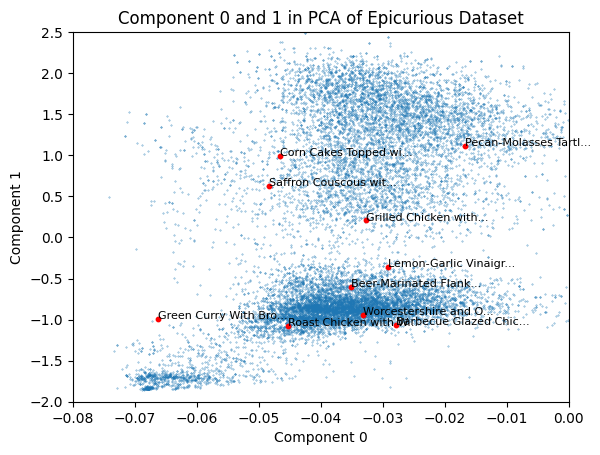

In [506]:
from matplotlib import pyplot as plt

# Plot all points in the background
plt.scatter(df_PCS['c0'], df_PCS['c1'], s=0.1, alpha=0.8)

# Select a few points to highlight and label
df_sample = df_PCS.sample(10, random_state=9)
plt.scatter(df_sample['c0'], df_sample['c1'], s=10, c='r')
for i in df_sample.index:
    annotation = df_sample.loc[i, 'title']
    if len(annotation) > 20:
        annotation = annotation[:20] + '...'
    plt.annotate(annotation, (df_sample.loc[i, 'c0'],df_sample.loc[i, 'c1']), size=8)

# Regularize plot
plt.xlim([-0.08,0]); plt.ylim([-2,2.5])
plt.xlabel('Component 0'); plt.ylabel('Component 1')
plt.title('Component 0 and 1 in PCA of Epicurious Dataset')
plt.show()

\pagebreak
(c) Below is the code to generate the variance-component graph.

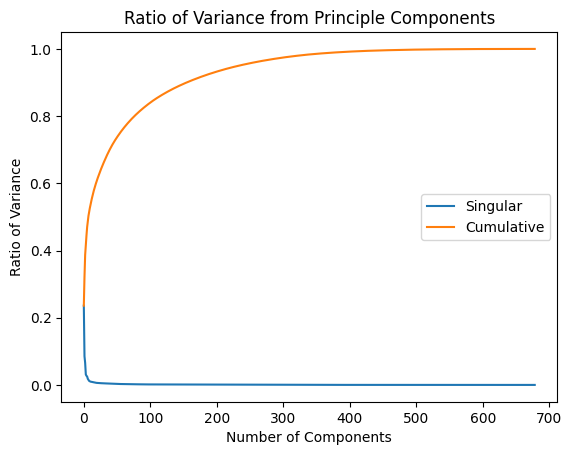

In [507]:
# Plot the variance fraction graph
plt.plot(model.explained_variance_ratio_, label='Singular')
plt.plot(model.explained_variance_ratio_.cumsum(), label='Cumulative')
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Variance')
plt.title('Ratio of Variance from Principle Components')
plt.legend(); plt.show()

\pagebreak
The graph is not incredibly informative due to the large number of components. Here is another plot with less components:

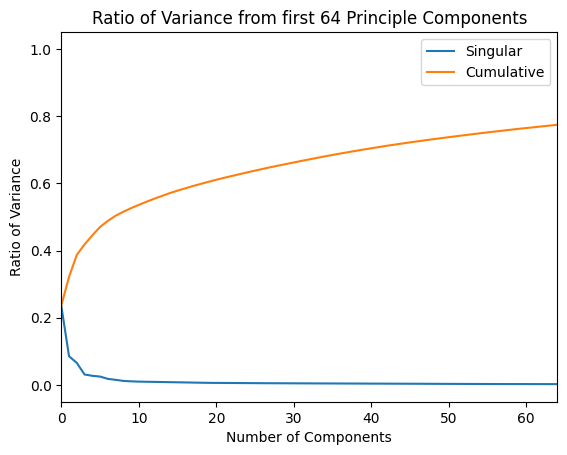

In [508]:
plt.plot(model.explained_variance_ratio_, label='Singular')
plt.plot(model.explained_variance_ratio_.cumsum(), label='Cumulative')
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Variance')
plt.title('Ratio of Variance from first 64 Principle Components')
plt.xlim([0,64])
plt.legend(); plt.show()

What fraction of Variance is explained by PC1 and PC2?

In [509]:
perc = np.round(model.explained_variance_ratio_[:2].sum()*100,2)
print('{}% of the variance can be explained by PC1 and PC2.'.format(perc))

32.13% of the variance can be explained by PC1 and PC2.


How many principle components are enough?

In [510]:
from kneed import KneeLocator

# Finding the elbow of the variance ratio curve
y = model.explained_variance_ratio_; x = range(len(y))
kl = KneeLocator(x, y, curve='convex', direction='decreasing')
print('{} principle components is enough for the dataset.'.format(kl.elbow))

16 principle components is enough for the dataset.


# Problem 2

(a) The implementation can be found as follow:

In [598]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Generate training and testing sets
df_PCS['cake'] = df['cake'].values.copy()
df_PCS_train, df_PCS_test = train_test_split(df_PCS)

# Train logistic model on different regularization strength
C = [2**i for i in range(-5, 6)]
log_models = {}
for c in C:
    log_models[c] = LogisticRegression(penalty='l1', solver='liblinear', C=c)
    log_models[c].fit(df_PCS_train[PCS_columns], df_PCS_train['cake'])

(b) The best regularization parameter is $c=0.25$.

In [599]:
from sklearn.metrics import roc_auc_score

# Traverse and find the model with the largest AUC
best_auc, best_c = 0, 0
for c in C:
    auc = roc_auc_score(
        df_PCS_test['cake'], 
        log_models[c].predict_proba(df_PCS_test[PCS_columns])[:, 1]
    )
    if auc > best_auc:
        best_c = c
        best_auc = auc
print('The best regularization strength is {}'.format(best_c))

The best regularization strength is 0.25


(c) The AUC score for the best model is a whopping 1.0!

In [600]:
print('The best model\'s AUC is {}'.format(best_auc))

The best model's AUC is 1.0


\pagebreak
(d) The plot for the feature coefficients are found below. Given the number of features, the plot would be only readable if a subset of the most important principle components are selected.

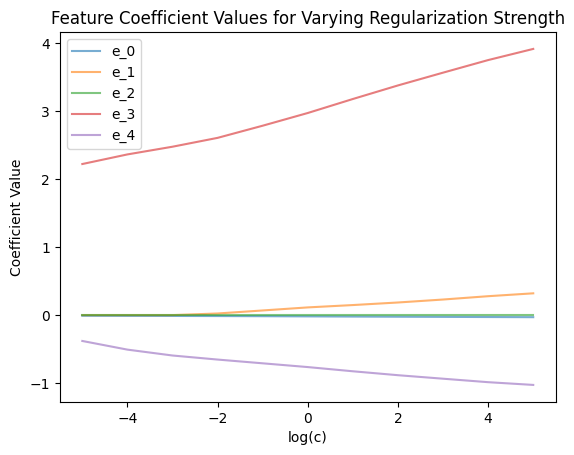

In [604]:
# Record values for each coefficient
X = range(-5, 6)    # Recall definition of C
coef = []
for x in X:
    coef.append([x] + log_models[2**x].coef_[0][:5].tolist())
columns = ['log(c)'] + ['e_{}'.format(i) for i in range(5)]
df_coef = pd.DataFrame(coef, columns=columns)
df_coef.plot.line(x='log(c)', y=['e_{}'.format(i) for i in range(5)], alpha=0.6)
plt.ylabel('Coefficient Value')
plt.xlabel('log(c)')
plt.title('Feature Coefficient Values for Varying Regularization Strength')
plt.show()

\pagebreak
# Problem 3
(a) Below is the implementation for K-means clustering:

In [614]:
from sklearn.cluster import KMeans

# Generate K-means clustering models for varying K
K = list(range(1,11))
models = {}
for k in K:
    models[k] = KMeans(n_clusters=k).fit(df[var_columns])

(b) Judging from the plot, the best value is $K=7$.

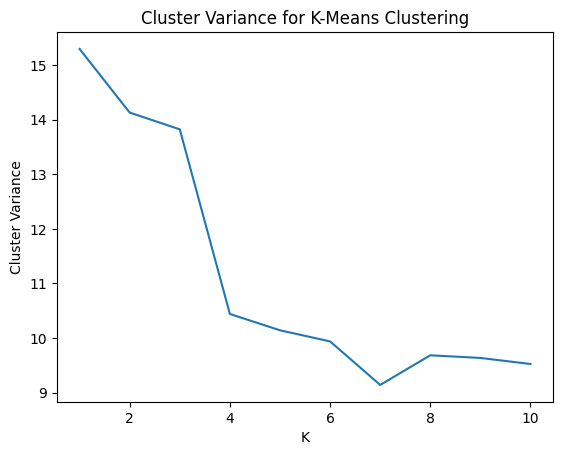

In [619]:
# Extract the SSE values
SSE = []
for k in K:
    SSE.append(models[k].inertia_ / df.shape[0])

# Plot the SSE values
plt.plot(K, SSE)
plt.xlabel('K')
plt.ylabel('Cluster Variance')
plt.title('Cluster Variance for K-Means Clustering')
plt.show()

\pagebreak
(d) The graphs can be found as follow:

In [676]:
import altair as alt
alt.data_transformers.disable_max_rows()

# Export the labels from K-means clustering
model = models[7]
df['label'] = model.labels_

# Perform PCA on normalized variables of df
N = len(var_columns)
model = PCA(n_components=N)
components = model.fit_transform(df[var_columns])[:,:10]
PCS_columns = ['c{}'.format(i) for i in range(components.shape[1])]
df_PCS = pd.DataFrame(components, columns=PCS_columns)
df_PCS['title'] = df['title'].values.copy()
df_PCS['label'] = df['label'].values.copy()

# Remove outliers
df_PCS = df_PCS[df_PCS['c0'] <= 0.01]

# Generate scatter plots using Altair
charts = []
for i in [0,1,2,3,4]:
    chart = alt.Chart(df_PCS).mark_circle(size=4,opacity=0.4).encode(
        x='c{}'.format(2*i),
        y='c{}'.format(2*i+1),
        color='label:N',
        tooltip=['title', 'label'],
    ).properties(
        title='PCA Scatter Plot with K-means Clustering Labels'
    )
    charts.append(chart)

alt.vconcat(
    charts[0] | charts[1],
    charts[2] | charts[3],
    charts[4], center=True
).save('3(d).png')

![figure 3(d)](3(d).png)

\pagebreak
(e) Consider the following labels:

In [724]:
# Generate scatter plots using Altair
df_temp = df_PCS[df_PCS['label']==0].copy()
sample = df_temp.sample(6, random_state=18)
background = alt.Chart(df_temp).mark_circle(
    size=4,
    opacity=0.5
).encode(
    x='c2',
    y='c3',
    color='label:N',
    tooltip=['title', 'label'],
).properties(
    title='PCA Scatter Plot with K-means Clustering Labels'
)
foreground = alt.Chart(sample).mark_circle(
    size=20,
    opacity=1,
    color='red'
).encode(
    x='c2',
    y='c3',
    tooltip=['title', 'label'],
)
text = foreground.mark_text(
    align='left',
    baseline='middle',
    dx=5
).encode(
    text='title'
)
(background + foreground + text).save('3(e)1.png')

Label 0 seems to be sweet food and snacks.

![figure 3(e)-1](3(e)1.png)

\pagebreak

In [735]:
# Generate scatter plots using Altair
df_temp = df_PCS[df_PCS['label']==4].copy()
sample = df_temp.sample(6, random_state=1)
background = alt.Chart(df_temp).mark_circle(
    size=4,
    opacity=0.5
).encode(
    x='c2',
    y='c3',
    color='label:N',
    tooltip=['title', 'label'],
).properties(
    title='PCA Scatter Plot with K-means Clustering Labels'
)
foreground = alt.Chart(sample).mark_circle(
    size=20,
    opacity=1,
    color='red'
).encode(
    x='c2',
    y='c3',
    tooltip=['title', 'label'],
)
text = foreground.mark_text(
    align='left',
    baseline='middle',
    dx=5
).encode(
    text='title'
)
(background + foreground + text).save('3(e)2.png')

Label 4 seems to be food for main course.

![figure 3(e)-2](3(e)2.png)